<a href="https://colab.research.google.com/github/zm6148/fNIRS_data_analysis/blob/master/fNIRS_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Learing on fNIRS data**


# 1. **Load processed data from google drive** 
*  Data was preprocessed on Matlab using homer2 scripts
*  filter -> de-trend ->  wavelet remove motion -> convert 



In [104]:
# Load the Drive helper and mount
from google.colab import drive
import numpy as np
from scipy import stats
from scipy import signal
import scipy.io
import os
import random
import pywt
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d
import tensorflow as tf
import shutil
from tensorflow.keras.optimizers import RMSprop


# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [105]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive/fNIRS_ML_colab/data"

ML_dataset.mat


In [0]:
# define useful functions

# function for calcualte accuracy
def predict_accuracy (answer, output):
    length = len(answer) 
    count = 0.0;
    for ii in range(0,length):
        if answer[ii] == output[ii]:
            count = count + 1 
    return (count/length) * 100

# random sample n from 12 blocks to calculate blkavg for each subject to increade 
# training data size
# def random_sample_training (training_data, training_SID, training_ROI, training_label):


# do block average on testing data sets
# each subject will have 2 blockaverage trace only
# def blvg_testing(testing_data, testing_SID, testing_ROI, testing_label):

block average trace is and all labels are stored in the .mat file
*   data for all 28 subjects recordings
*   SID for subject label
*   ROI for region of interest label(1: left cIFS; 2: right cIFS; 3: left STG; 4: right STG)
*   label for task type label (1: active; 0: passive)





In [0]:
# navigate to the data folder and load the preprocessed files
ML_dataset = scipy.io.loadmat('/content/drive/My Drive/fNIRS_ML_colab/data/ML_dataset.mat')
data = np.asarray(ML_dataset['data'])
SID = np.asarray(ML_dataset['SID'])
ROI = np.asarray(ML_dataset['ROI'])
label = np.asarray(ML_dataset['label'])

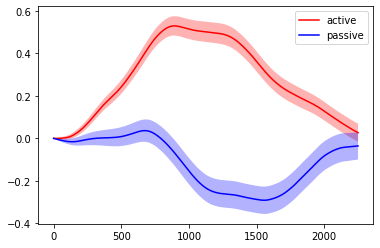

In [108]:
# Plot blkavg and check to be sure we got the data right
active_index = np.where(label == 1)[0]
passive_index = np.where(label == 0)[0]
data_active = data[active_index, :]
data_passive = data[passive_index, :]

fig = plt.figure('active vs. passive')    
y = np.mean(data_active,axis = 0)
SE = np.std(data_active, axis = 0);
SEM = SE/np.sqrt(len(data_active));
plt.plot(range(len(y)), y, 'r', label = 'active')
plt.fill_between(range(len(y)), y - SEM, y + SEM, alpha=0.3, facecolor='r')
    
y = np.mean(data_passive,axis = 0)
SE = np.std(data_passive, axis = 0);
SEM = SE/np.sqrt(len(data_active));
plt.plot(range(len(y)), y, 'b', label = 'passive')
plt.fill_between(range(len(y)), y - SEM, y + SEM, alpha=0.3, facecolor='b')
plt.legend()
plt.show()

# **2. Prepare training and testing data sets**

In [0]:
# choose 8 subject as tesing, the rest as training
all_subject_ID = list(np.unique(SID))
# SID 
testing_SID = random.sample(all_subject_ID, 8)
training_SID = np.delete(all_subject_ID, np.where(all_subject_ID == all_subject_ID))
# data
testing_data = data[np.where(SID == testing_SID)[0]]
training_data = data[np.where(SID == training_SID)[0]]
# ROI
testing_ROI = ROI[np.where(SID == testing_SID)[0]]
training_ROI = ROI[np.where(SID == training_SID)[0]]
# label
testing_label = label[np.where(SID == testing_SID)[0]]
training_label = label[np.where(SID == training_SID)[0]]


# X is the training data set
# y is the class label
X = training_data
y = training_label[:,0]

# PCA for projection plot later
pca_a = PCA(n_components=8)
testing_data_r_a = pca_a.fit(testing_data).transform(testing_data)

# **3. Try different ML methods**
*   SVM
*   Decision tree 
*   Neural Network (?)

1. Simple SVM

In [111]:
# simplest SVM with no feature selection or extraction
# train svm
clf_svm= svm.SVC()
clf_svm.fit(X, y)  
# use clf to perdict 
out_put_SVM = clf_svm.predict(testing_data)     
# see how good it is
per_correct_SVM = predict_accuracy(testing_label, out_put_SVM)
print("\nSimple SVM accuracy on test data is {:0.2f}%.\n".format(per_correct_SVM))


Simple SVM accuracy on test data is 71.25%.



2. DT and RF

In [112]:
# decision tree and random forest
# each time take 80% of the training data to build a tree, build 10 trees
# voting at the end
clf_DT = tree.DecisionTreeClassifier()
bag = BaggingClassifier(clf_DT, n_estimators=10, max_samples=0.8, random_state=1)
clf_DT = bag.fit(X, y)

# use forest to perdict 
out_put_DT = clf_DT.predict(testing_data)
# see how good it is
per_correct_DT = predict_accuracy(testing_label, out_put_DT)
print("\nDT accuracy on test data is {:0.2f}%.\n".format(per_correct_DT))


DT accuracy on test data is 97.22%.



3. NN (?)


> Generate training set from stft from training data and save

In [113]:
# NN implemented in tensorflow
# 1. perform stft on each trainset row, use the stft plot as the input for training
# 2. apply NN using tensor flow
# sampling frequence Fs = 50 Hz
Fs = 50
N = 10 * Fs
nperseg = 5
amp = 2 * np.sqrt(2)

# training data
fig_path='/content/drive/My Drive/fNIRS_ML_colab/images/'
fig_path_active = '/content/drive/My Drive/fNIRS_ML_colab/images/active/'
fig_path_passive = '/content/drive/My Drive/fNIRS_ML_colab/images/passive/'
if os.path.exists(fig_path):
  shutil.rmtree(fig_path)
if not os.path.exists(fig_path_active) or not os.path.exists(fig_path_passive) or not os.path.exists(fig_path):
  os.makedirs(fig_path)
  os.makedirs(fig_path_active)
  os.makedirs(fig_path_passive)
for ii in range(len(X)):
  # generate graph as save as input for training
  f, t, Zxx = signal.stft(X[ii,:], fs=Fs, window='hann', nperseg=3, noverlap=nperseg // 2, boundary='zeros')
  fig = plt.figure(1)
  plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=amp)
  if training_label[ii] == 1:
    fig_name = 'active_'+str(ii)+'.png'
    fig_filename = os.path.join(fig_path_active, fig_name)
    fig.savefig(fig_filename)
  else:
    fig_name = 'passive_'+str(ii)+'.png'
    fig_filename = os.path.join(fig_path_passive, fig_name)
    fig.savefig(fig_filename)
  plt.close()
    
# testing data
fig_path='/content/drive/My Drive/fNIRS_ML_colab/images_testing/'
fig_path_active = '/content/drive/My Drive/fNIRS_ML_colab/images_testing/active/'
fig_path_passive = '/content/drive/My Drive/fNIRS_ML_colab/images_testing/passive/'
if os.path.exists(fig_path):
  shutil.rmtree(fig_path)
if not os.path.exists(fig_path_active) or not os.path.exists(fig_path_passive) or not os.path.exists(fig_path):
  os.makedirs(fig_path)
  os.makedirs(fig_path_active)
  os.makedirs(fig_path_passive)
for ii in range(len(testing_data)):
  # generate graph as save as input for training
  f, t, Zxx = signal.stft(testing_data[ii,:], fs=Fs, window='hann', nperseg=3, noverlap=nperseg // 2, boundary='zeros')
  fig = plt.figure(1)
  plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=amp)
  if testing_label[ii] == 1:
    fig_name = 'active_'+str(ii)+'.png'
    fig_filename = os.path.join(fig_path_active, fig_name)
    fig.savefig(fig_filename)
  else:
    fig_name = 'passive_'+str(ii)+'.png'
    fig_filename = os.path.join(fig_path_passive, fig_name)
    fig.savefig(fig_filename)
  plt.close()

print("All images saved")

All images saved


In [114]:
# load from images folder and prepare training set
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/content/drive/My Drive/fNIRS_ML_colab/images/',  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow training images in batches of 128 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        '/content/drive/My Drive/fNIRS_ML_colab/images_testing/',  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 1968 images belonging to 2 classes.
Found 720 images belonging to 2 classes.


In [115]:
# build model then start training
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()
# compile
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 18496)           

In [0]:
# start training and testing
history = model.fit_generator(
      train_generator,
      steps_per_epoch=50,  
      epochs=50,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8)

Epoch 1/50
50/50 [==============================] - 142s 3s/step - loss: 0.6658 - acc: 0.5958 - val_loss: 0.6703 - val_acc: 0.5781
Epoch 2/50
50/50 [==============================] - 138s 3s/step - loss: 0.6591 - acc: 0.6038 - val_loss: 0.6681 - val_acc: 0.6133
Epoch 3/50
50/50 [==============================] - 141s 3s/step - loss: 0.6432 - acc: 0.6293 - val_loss: 0.6379 - val_acc: 0.5898
Epoch 4/50
50/50 [==============================] - 138s 3s/step - loss: 0.6169 - acc: 0.6586 - val_loss: 0.6419 - val_acc: 0.6133
Epoch 5/50
50/50 [==============================] - 139s 3s/step - loss: 0.5800 - acc: 0.6972 - val_loss: 0.5398 - val_acc: 0.7266
Epoch 6/50
50/50 [==============================] - 137s 3s/step - loss: 0.5394 - acc: 0.7260 - val_loss: 0.5098 - val_acc: 0.7617
Epoch 7/50
50/50 [==============================] - 139s 3s/step - loss: 0.4850 - acc: 0.7662 - val_loss: 0.4150 - val_acc: 0.8086
Epoch 8/50
50/50 [==============================] - 141s 3s/step - loss: 0.4219 - a

Visualize 2 classification results using 3d projection of the top 3 PCA components

In [0]:
# 1 row 2 colummns
ax1 = plt.subplot2grid((1, 4), (0, 1), colspan=1, projection='3d')
ax2 = plt.subplot2grid((1, 4), (0, 3), colspan=1, projection='3d')

# SVM
# projected top 3 eigen vector plot
class_1_index = np.where(out_put_SVM == 1)[0]
class_2_index = np.where(out_put_SVM == 0)[0]
# plot 
ax1.set_title('SVM')
ax1.scatter(testing_data_r_a[class_1_index,1], 
            testing_data_r_a[class_1_index,2],
            testing_data_r_a[class_1_index,0],
            marker = 'o',color='r',label='Active')
ax1.scatter(testing_data_r_a[class_2_index,1],
            testing_data_r_a[class_2_index,2],
            testing_data_r_a[class_2_index,0],
            marker = '^',color= 'b',label='Passive')
#ax1.legend(loc='left', mode="expand", borderaxespad=0.)

# projected top 3 eigen vector plot
class_1_index = np.where(out_put_DT == 1)[0]
class_2_index = np.where(out_put_DT == 0)[0]
# plot 
ax2.set_title('DT and RF')
ax2.scatter(testing_data_r_a[class_1_index,1],
            testing_data_r_a[class_1_index,2],
            testing_data_r_a[class_1_index,0],
            marker = 'o',color='r',label='Active')
ax2.scatter(testing_data_r_a[class_2_index,1],
            testing_data_r_a[class_2_index,2],
            testing_data_r_a[class_2_index,0],
            marker = '^',color='b',label='Passive')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
